In [99]:
import pandas as pd
import numpy as np
import requests
from IPython.display import HTML, display
from bs4 import BeautifulSoup
from bs4 import Comment
import json
import html
import re
import urllib.parse
from threading import Thread
from html import unescape
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns
import datetime as datetime
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
talks = pd.read_pickle('../datasets/videosData.pkl')
print(len(talks))
talks.head(2)

78391


,title,speaker,event,videoId,titleRaw,publishedTimeRaw,likes,dislikes,lengthSeconds,keywords,views,videoDescription,currentDate,publishDate,text,nouns
-eLgCDFKD7s,The Art of living with Leopards,Nikit Surve,TEDxVileParle,-eLgCDFKD7s,The Art of living with Leopards | Nikit Surve ...,7 months ago,10,0,1006,"[TEDxTalks, English, Global Issues, Animals]",544,Nikit talks about wildlife and his work within...,1.57697e+09,2019-05-17 00:00:00,I don't have never was in Mumbai so muchall of...,mumbai muchall cause three-second ofthe pinto ...
DF4ipJE_t_A,Paisajes invisibles,Francisco García & Manuel Bugallo,TEDxGalicia,DF4ipJE_t_A,Paisajes invisibles | Francisco García & Manue...,7 months ago,21,0,723,"[TEDxTalks, Spanish, Global Issues, Environment]",761,Fran y Manuel nos ofrecen una mirada diferente...,1.57699e+09,2019-05-17 00:00:00,I always loved the Mediterranean maybe because...,mediterranean north phrase feride scenography ...


In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_en = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matias\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
talksSample = talks.sample(9000)

In [4]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=.05)
X = vectorizer.fit_transform(talks.nouns)

In [5]:
from sklearn.decomposition import NMF

n_topics = 9
cls = NMF(n_components=n_topics)
cls.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=9, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [6]:
talksToC = talks

# proba = cls.transform(vectorizer.transform(talksToC.nouns))
proba = cls.transform(X)
cats = proba.argsort(axis=1)[:, -1]
probaScore = [round(proba[i][cats[i]], 4) for i in range(len(cats))]

In [7]:
talksC = talksToC.copy()
talksC['cat'] = cats
talksC['probaScore'] = probaScore
talksC.head(2)
talksC['views'] = talksC.views.astype(int)
talksC['likes'] = talksC.likes.astype(int)
talksC['dislikes'] = talksC.dislikes.astype(int)
for i in range(len(proba[0])):
    talksC.loc[:,'proba_'+str(i)] = proba[:, i]

In [8]:
unique, counts = np.unique(talksC.cat, return_counts=True)
dict(zip(unique, counts))

{0: 9516,
 1: 4988,
 2: 14811,
 3: 4473,
 4: 7551,
 5: 5812,
 6: 13674,
 7: 11500,
 8: 6066}

In [36]:
talksC = talksC.loc[~talksC.index.duplicated(keep='first')]

In [189]:
# Exportar Modelo a archivo binario
# import pickle
# filename = '../models/vectorsTalks.pkl'
# with open(filename, 'wb') as vc:
#     pickle.dump(vectorizer, vc)
    
# filename = '../models/clsTalksCat.pkl'
# with open(filename, 'wb') as clFile:
#     pickle.dump(cls, clFile)

In [48]:
n_top_words = 15
feature_names = vectorizer.get_feature_names()

for i, topic_vec in enumerate(cls.components_): #por cada cluster
    print('Grupo %d:' % (i), '%d charlas' % counts[i]),
    print('Tags:', ' '.join([feature_names[fid] for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]]))
    for t in talksC[talksC.cat == i].sort_values('probaScore', ascending=False).index[:5]:
        print('\t', talksC.loc[t, ['titleRaw']][0])
        print('\t', 'https://www.youtube.com/watch?v='+talksC.loc[t, ['videoId']][0])
    print('')

Grupo 0: 9516 charlas
Tags: kind things thing lot time way bit sort idea people art stuff okay right yeah
	 Physics as a process: Cass Sackett at TEDxUVA
	 https://www.youtube.com/watch?v=BHlqXZgoMkc
	 How to speak with impact | Peter Hopwood | TEDxUniversityofZagreb
	 https://www.youtube.com/watch?v=lukeZyNHZzk
	 Future Perfect: Picturing the Anthropocene | Danny Goodwin | TEDxSchenectady
	 https://www.youtube.com/watch?v=NdvYfqbvUOE
	 The Folk Process: John Egenes  at TEDxDunedin
	 https://www.youtube.com/watch?v=GGhtCTfzbs8
	 Sustainable Growth | Allen Hulsey | TEDxYouth@FMVErenköyIşık
	 https://www.youtube.com/watch?v=oyzhuzNGVlk

Grupo 1: 4988 charlas
Tags: music applause song sound dance yes piece art oh artists love voice language thank stage
	 The true sign of intelligence is imagination. | Joe Kuncheria | TEDxYouth@TCHS
	 https://www.youtube.com/watch?v=CNPPmqt-0PE
	 The Opening - Without You - Gone - Show Me | Gravity Duo | TEDxCiutatVellaDeValencia
	 https://www.youtube.com/

In [38]:
nombres_grupos = [
    'art and comunication',
    'performance',
    'life, motivation',
    'gender',
    'education',
    'brain',
    'technology',
    'cities',
    'food'
]

talksC['catName'] = talksC.cat.replace({i:nombres_grupos[i] for i in range(len(nombres_grupos))})

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
talksC.groupby('cat').median()

,likes,dislikes,lengthSeconds,views,probaScore,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8
cat,,,,,,,,,,,,,,
0,22.0,1.0,889.0,1666.0,0.03380,0.033843,0.000827,0.009943,0.000000,0.001531,0.000566,0.008438,0.009239,0.000930
1,19.0,1.0,808.0,1004.0,0.07205,0.008719,0.072046,0.008589,0.000000,0.000465,0.000000,0.002552,0.004253,0.000194
2,34.0,1.0,839.0,1902.0,0.03460,0.009048,0.001017,0.034578,0.000392,0.002227,0.000659,0.003695,0.009696,0.001326
3,33.0,2.0,820.0,1980.0,0.05870,0.007340,0.000486,0.010956,0.058678,0.002762,0.000000,0.004923,0.008034,0.000358
4,23.0,1.0,814.0,1494.0,0.04660,0.008981,0.000489,0.010023,0.000000,0.046577,0.000400,0.007271,0.007948,0.000542
5,40.0,2.0,880.0,2801.0,0.04380,0.007630,0.000370,0.009819,0.000289,0.000488,0.043767,0.006275,0.004543,0.001559
6,20.0,1.0,867.0,1467.0,0.03590,0.008316,0.000436,0.005094,0.000014,0.000859,0.000686,0.035946,0.009738,0.001201
7,23.0,1.0,836.0,1443.5,0.03590,0.010398,0.000596,0.011986,0.001158,0.003537,0.000000,0.008899,0.035929,0.002218
8,22.0,1.0,839.0,1528.0,0.04370,0.006980,0.000195,0.005831,0.000000,0.000060,0.000000,0.009895,0.007339,0.043687


In [40]:
from scipy import stats
np.abs(stats.zscore(talksC.views))


dfCortado = talksC[talksC.views.between(talksC.views.quantile(.15), talksC.views.quantile(.85))]

col='views'
# df = talksC[np.abs((talksC[col] - talksC[col].mean())/talksC[col].std(ddof=0)) > 3]
print(len(talksC),len(dfCortado))


77667 54398


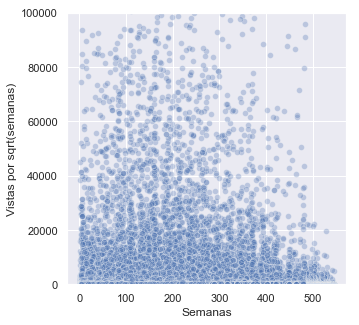

In [120]:
y = talksC.views / np.sqrt(talksC.publishDate.apply(lambda x: round((datetime.datetime.now() - x).days/7)))
x = talksC.publishDate.apply(lambda x: round((datetime.datetime.now() - x).days/7))

fig = plt.subplots(figsize=(5,5))
ax = sns.scatterplot(
    y = y,
    x = x,
    alpha = 0.3
)
ax.set(
    ylabel='Vistas por sqrt(semanas)',
    xlabel='Semanas',
    ylim=(0,100000)
)
plt.show()

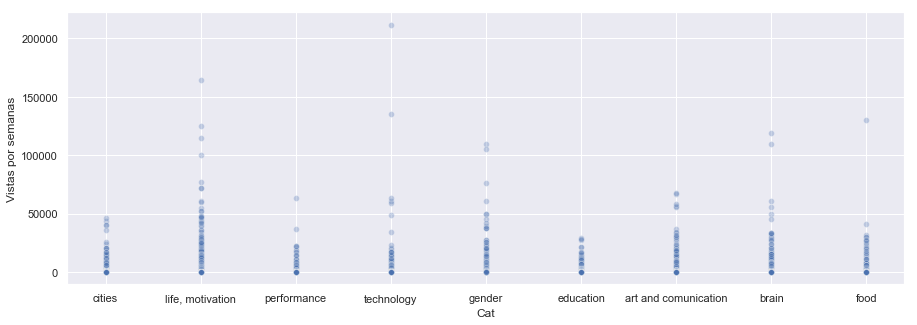

In [153]:
y = talksC.views / talksC.publishDate.apply(lambda x: round((datetime.datetime.now() - x).days/7))
x = talksC.catName.values

fig = plt.subplots(figsize=(15,5))
ax = sns.scatterplot(
    x = x,
    y = y,
    alpha = 0.3,
)
ax.set(
    ylabel='Vistas por semanas',
    xlabel='Cat',
)
plt.show()

5741

In [1]:
yy = talksC.groupby('catName').apply(
    lambda df: np.mean(df.views / df.publishDate.apply(lambda x: round((datetime.datetime.now() - x).days/7)))
)

xx = talksC.groupby('catName').count().iloc[:,0]

y = yy.values
x = yy.index.map(lambda x: x+' ('+str(xx[x])+' talks)')

fig = plt.subplots(figsize=(15,5))
ax = sns.barplot(
    x = x,
    y = y,
    alpha = 1,
)
ax.set(
    ylabel='Promedio vistas por semanas',
    xlabel='Cat',
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-20)
plt.show()

NameError: name 'talksC' is not defined

In [168]:
talksC

,title,speaker,event,videoId,titleRaw,publishedTimeRaw,likes,dislikes,lengthSeconds,keywords,...,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8,catName
-eLgCDFKD7s,The Art of living with Leopards,Nikit Surve,TEDxVileParle,-eLgCDFKD7s,The Art of living with Leopards | Nikit Surve ...,7 months ago,10,0,1006,"[TEDxTalks, English, Global Issues, Animals]",...,0.018192,0.000685,0.021245,0.001722,0.001841,0.000889,0.004962,0.046081,0.024592,cities
DF4ipJE_t_A,Paisajes invisibles,Francisco García & Manuel Bugallo,TEDxGalicia,DF4ipJE_t_A,Paisajes invisibles | Francisco García & Manue...,7 months ago,21,0,723,"[TEDxTalks, Spanish, Global Issues, Environment]",...,0.013632,0.008252,0.000000,0.000000,0.000000,0.002486,0.026478,0.041793,0.010615,cities
587FCkioktM,Ce que j’ai appris de 15 000km à vélo,Pierre Bouillot,TEDxINSA,587FCkioktM,Ce que j’ai appris de 15 000km à vélo | Pierre...,7 months ago,6,0,890,"[TEDxTalks, French, Life, Adventure, Explorati...",...,0.013552,0.004111,0.036030,0.000307,0.000000,0.002287,0.006223,0.009115,0.031215,"life, motivation"
UY5bDA63b7k,O Poder do Imprevisto na Música,André Santos,TEDxFunchal,UY5bDA63b7k,O Poder do Imprevisto na Música | André Santos...,7 months ago,44,1,1032,"[TEDxTalks, Portuguese, Art, Connection, Initi...",...,0.018532,0.089188,0.020090,0.000000,0.000000,0.006350,0.004414,0.010269,0.000311,performance
xUZf2ZUl1xA,My mom read the news every day. How journalism...,Florence Rogers,TEDxValleyHS,xUZf2ZUl1xA,My mom read the news every day. How journalism...,1 week ago,3,0,880,"[TEDxTalks, English, Humanities, Humanity, Ide...",...,0.002258,0.000000,0.011874,0.000544,0.004634,0.000000,0.012679,0.037149,0.000130,cities
m5jeaTARaUE,The Only Way To Predict The Future Is To Creat...,Bethany Girma,TEDxValleyHS,m5jeaTARaUE,The Only Way To Predict The Future Is To Creat...,1 week ago,23,8,514,"[TEDxTalks, English, Life, Achievement, Advent...",...,0.017507,0.001973,0.028334,0.000000,0.012269,0.000000,0.004835,0.000000,0.020939,"life, motivation"
12D6gTp2924,Come e perchè mantenere pulito lo Spazio,Rosario Nasca,TEDxBarletta,12D6gTp2924,Come e perchè mantenere pulito lo Spazio | Ros...,7 months ago,20,0,851,"[TEDxTalks, Italian, Global Issues, Environmen...",...,0.012060,0.005585,0.000827,0.000266,0.000000,0.000000,0.033313,0.000000,0.019296,technology
P50Rk_WozbU,Banking for the Unbanked - Katharine Budd,Katharine Budd,TEDxAlWaslWomen,P50Rk_WozbU,Banking for the Unbanked - Katharine Budd | Ka...,7 months ago,3,0,923,"[TEDxTalks, English, Global Issues, Developing...",...,0.003434,0.000000,0.008445,0.028151,0.000000,0.000000,0.021414,0.036358,0.000000,cities
mKbbC9zx8oA,Turning Loss into Legacy - Danielle Wilson Naqvi,Danielle Wilson Naqvi,TEDxAlWaslWomen,mKbbC9zx8oA,Turning Loss into Legacy - Danielle Wilson Naq...,7 months ago,0,0,1121,"[TEDxTalks, English, Life, Children, Death, De...",...,0.000000,0.000302,0.042338,0.004942,0.000000,0.010567,0.000911,0.000000,0.003083,"life, motivation"
Dg5ifmBfBbg,Gender equality: taking action at a local level,Derek O'Connell,TEDxMackay,Dg5ifmBfBbg,Gender equality: taking action at a local leve...,7 months ago,3,1,995,"[TEDxTalks, English, Life, Activism, Evolution...",...,0.010550,0.004375,0.024679,0.105369,0.000000,0.000000,0.012546,0.005001,0.000000,gender


In [ ]:
dfToPlot = talksC.sample(frac=0.2).copy()

trace1 = go.Scatter(
    name='Charlas',
    x= dfToPlot.cat,
    y= dfToPlot.views,
    mode='markers',
    marker={
        'opacity': .05,
        'size': 5
    }
)
trace2 = go.Scatter(
    name='Promedio',
    mode='markers',
    x = dfToPlot.groupby('cat').mean().index,
    y = dfToPlot.groupby('cat').mean().views,
    marker={
        'size':10
    }
)
trace3 = go.Scatter(
    name='Media',
    mode='markers',
    x = dfToPlot.groupby('cat').median().index,
    y = dfToPlot.groupby('cat').median().views,
    marker={
        'size':10
    }
)
layout = go.Layout(
    title='Clasificación de %d charlas TEDx' % len(dfToPlot),
    yaxis = dict(
        range = [0, 800000],
        title='Views',
    ),
    xaxis = dict(
        title='Categoria',
        tickvals = list(range(10)),
        ticktext = nombres_grupos
    )
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
iplot(fig)

In [163]:
talksC[['title','views','likes','catName']].sort_values('views', ascending=False).head()

,title,views,likes,catName
hqKafI7Amd8,Top hacker shows us how it's done,21365801,211804,Comedia
d0yGdNEWdn0,How to learn any language in six months,19328919,344741,Eucacion
w-HYZv6HzAs,The skill of self confidence,18103143,288020,Comedia
5MgBikgcWnY,The first 20 hours -- how to learn anything,16594393,314252,Comedia
F4Zu5ZZAG7I,7 Ways to Make a Conversation With Anyone,14918884,263010,Comedia


In [167]:
talksC.loc['hqKafI7Amd8','text']

'Translated by: Rik Delaet Checked by: Christel Foncke  So this is a hotel room, like the one in which I stay.  Sometimes I get bored.  Such a room does not offer much entertainment.  But a hacker she is a little interesting,  for which television is different than at home,  it is a node on a network.  That means I can mess with it.  I plug a small device like this in my computer.  It is an infrared transceiver that I can send the codes  which can broadcast the TV remote control and some other codes.  Well, I can watch free movies.  (Laughter)  That makes me not so much, but I can also play video games.  Hey, but what is this?  I can not do this on my TV in my hotel room,  I can also operate the TV in your hotel room.  (Laughter)  So I can see where you look,  You know, the data on your TV  when you surf the web on your hotel TV.  I can see you do it.  Sometimes it\'s very interesting.  Transfer of funds.  Really big payments.  You never know what people want to do  while they surf the

In [196]:
talksC.sort_values('proba_7', ascending=False)

,title,speaker,event,videoId,titleRaw,publishedTimeRaw,likes,dislikes,lengthSeconds,keywords,...,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8,proba_9
Q2G2eky6Azw,Is the new generation asleep?,Pierre-Emmanuel Barré,TEDxParis,Q2G2eky6Azw,Is the new generation asleep? | Pierre-Emmanue...,2 years ago,8689,440,542,"[TEDxTalks, French, France, Entertainment, Com...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.379959,0.000000,0.000000
xdROsuWCz7w,,Cyrille de Lasteyrie Vinvin,TEDxParis,xdROsuWCz7w,Cyrille de Lasteyrie Vinvin at TEDxParis,9 years ago,171,10,1056,"[vinvin, paris, ted talks, cyrille de lasteyri...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000533,0.000000,0.366643,0.000000,0.000000
gdCJakiJAkE,La SLOW conclusion de TEDxParis 2017,Haroun .,TEDxParis,gdCJakiJAkE,La SLOW conclusion de TEDxParis 2017 | Haroun ...,1 year ago,15489,467,571,"[TEDxTalks, French, Entertainment, Art, Humor]",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.293056,0.000000,0.000000
79zra755WgA,Saying YES! to your Weirdness,JP Sears,TEDxCardiffbytheSea,79zra755WgA,Saying YES! to your Weirdness | JP Sears | TED...,1 year ago,20002,402,1609,"[TEDxTalks, English, United States, Life, Come...",...,0.000000,0.000000,0.000250,0.001588,0.000000,0.000000,0.000000,0.277513,0.002013,0.000000
TRE4-ll42lE,How living more honestly leads to a better life,Sabrina Jalees,TEDxToronto,TRE4-ll42lE,How living more honestly leads to a better lif...,4 years ago,912,24,674,"[Relationships/Romance, Lifestyle, ted talks, ...",...,0.000000,0.000000,0.000000,0.003589,0.000000,0.000000,0.000000,0.275640,0.000000,0.000000
DdWECtyM36s,Being silly,Sam Simmons,TEDxSydney,DdWECtyM36s,Being silly: Sam Simmons at TEDxSydney,6 years ago,1396,66,653,"[ted talks, tedx, Silly, TEDxSydney, ted talk,...",...,0.000000,0.039139,0.000000,0.000000,0.000000,0.010678,0.000000,0.243062,0.000000,0.000000
gtFRfclnyZU,TEDxRotterdam,Geert Chatrou,Becoming world champion in whistling,gtFRfclnyZU,TEDxRotterdam - Geert Chatrou - Becoming worl...,8 years ago,38,1,757,"[tedx talk, tedx, ted x, ted talk, TEDxRotterd...",...,0.000000,0.046697,0.000000,0.000000,0.000000,0.000000,0.000000,0.234742,0.000000,0.000000
55If9IfxgOg,Why Computers Baffle Me,Andrew Norelli,TEDxMarin,55If9IfxgOg,Why Computers Baffle Me | Andrew Norelli | TED...,2 years ago,804,155,291,[TEDx],...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.231701,0.000000,0.000000
Bk0ZXeWKD1o,World Laughter Master,Belachew Girma,TEDxAddis,Bk0ZXeWKD1o,World Laughter Master: Belachew Girma at TEDxA...,8 years ago,294,14,1464,"[ted talks, tedx talks, ted talk, ted x, TEDx,...",...,0.000000,0.011559,0.003714,0.007539,0.007000,0.006932,0.005273,0.221790,0.003498,0.000000
EO717tfvVFU,"La compta c’était marrant, l’humour c’est sérieux",Thomas Wiesel,TEDxFribourg,EO717tfvVFU,"La compta c’était marrant, l’humour c’est séri...",2 years ago,8593,369,1078,"[TEDxTalks, French, Switzerland, Entertainment]",...,0.006650,0.000000,0.000000,0.012619,0.007681,0.000059,0.005610,0.219514,0.000000,0.000000


In [205]:
trace1 = go.Scatter(
    name='7',
    x= talksC.proba_7,
    y= talksC.views,
    mode='markers',
    marker={
        'opacity': 1,
        'size': 3
    }
)
trace2 = go.Scatter(
    name='0',
    x= dfCortado.proba_2,
    y= dfCortado.views,
    mode='markers',
    marker={
        'opacity': 1,
        'size': 5
    }
)
layout = go.Layout(
#     title='Clasificación de %d charlas TEDx' % len(dfToPlot),
    yaxis = dict(
#         range = [0, 50000],
        title='Views',
    ),
    xaxis = dict(
        title='Probabilidad de pertenecer al grupo 8',
#         range=[0,0.08]
#         tickvals = list(range(10)),
#         ticktext = nombres_grupos
    )
)
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)